In [ ]:
import cv2
import dlib
import gdown
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
from sklearn import metrics
from scipy.spatial import distance
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

dataset_url = 'https://drive.google.com/uc?id=1xFiYsULlQWWmi2Ai0fHjtApniP5Pscuf'
dataset_path = './ferdata.csv'
gdown.download(dataset_url, dataset_path, True)

dlibshape_url = 'https://drive.google.com/uc?id=17D3D89Gke6i5nKOvmsbPslrGg5rVgOwg'
dlibshape_path ='./shape_predictor_68_face_landmarks.dat'
gdown.download(dlibshape_url, dlibshape_path, True)
pureX_url = 'https://drive.google.com/uc?id=1CglpXodenZVrkaZehLtfykfQv8dcnfO9'
pureX_path = './pureX.npy'
gdown.download(pureX_url, pureX_path,True)

dataX_url = 'https://drive.google.com/uc?id=1sIJGxUM6rNBcWxucs6iynDepeKU1Q56p'
dataX_path = './dataX.npy'
gdown.download(dataX_url, dataX_path, True)

dataY_url = 'https://drive.google.com/uc?id=1Rfr0OP-hZO_UZfuOyMNR2RjNRAro85zE'
dataY_path = './dataY.npy'
gdown.download(dataY_url, dataY_path, True)

print ("Data Downloaded")


Data Downloaded!


In [ ]:
label_map = {0:"ANGRY",1:"HAPPY",2:"SAD",3:"SURPRISE",4:"NEUTRAL"}
df = pd.read_csv("./ferdata.csv")
df.head()

,emotion,pixels,Usage
0,0,215 216 215 215 215 216 216 216 214 178 81 30 ...,Training
1,4,244 244 244 244 243 244 242 190 132 93 81 73 7...,Training
2,4,255 255 255 255 255 255 255 255 255 255 255 25...,Training
3,4,38 56 60 52 58 65 53 44 35 48 59 60 36 30 21 3...,Training
4,4,77 40 27 21 22 25 20 31 27 17 27 42 47 55 51 4...,Training


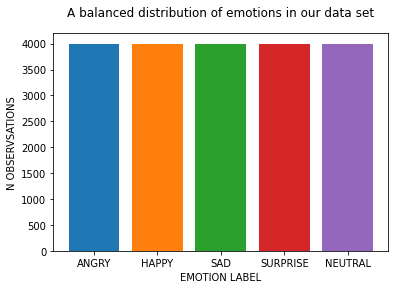

In [ ]:
emotion_labels = [label_map[i] for i in label_map.keys()]
emotion_counts = [np.sum(df["emotion"] == i) for i in range(len(label_map))]
[plt.bar(x = emotion_labels[i], height = emotion_counts[i] ) for i in range(len(emotion_labels))] 
plt.xlabel('EMOTION LABEL')
plt.ylabel('N OBSERVSATIONS')
plt.title('A balanced distribution of emotions in our data set', y=1.05); 

In [ ]:
import os

In [ ]:
os.listdir() 

['.config',
 'shape_predictor_68_face_landmarks.dat',
 'pureX.npy',
 'ferdata.csv',
 'dataY.npy',
 'dataX.npy',
 'sample_data']

In [ ]:

predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
def get_landmarks(image):
  rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
  landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
  return image,landmarks
def image_landmarks(image,face_landmarks):
  radius = -2
  circle_thickness = 1
  image_copy = image.copy()
  for (x, y) in face_landmarks:
    cv2.circle(image_copy, (x, y), circle_thickness, (255,0,0), radius)
    
  plt.imshow(image_copy, interpolation='nearest', cmap='Greys_r')
  plt.xticks([]); plt.yticks([])
  plt.show()

def pixels_image(img_pixels,plt_flag):
  width = 48
  height = 48
  
  image = np.fromstring(img_pixels, dtype=np.uint8, sep=" ").reshape((height, width))
  
  if plt_flag:
      plt.imshow(image, interpolation='nearest', cmap="Greys_r")
      plt.xticks([]); plt.yticks([])
      plt.show()
      
      
  return image


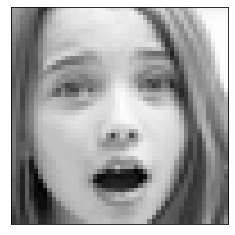

In [ ]:
i_index = np.random.randint(len(df))

image_pixels = df['pixels'][i_index]        

image = pixels_image(image_pixels, True)

In [ ]:
label = df['emotion'][i_index]
label = label_map[label]
print(label)

SURPRISE


####Plot Facial Landmarks on the Datapoints

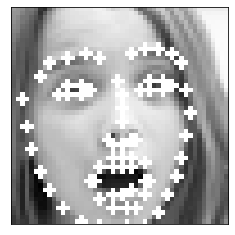

In [ ]:
image, facial_landmarks = get_landmarks(image)
image_landmarks(image,facial_landmarks)

In [ ]:

def landmarks_edist(face_landmarks):

    e_dist = []
    for i in face_landmarks:
      for j in face_landmarks:
        e_dist.append(distance.euclidean(i,j))
    return e_dist


In [ ]:
def preprocess_data(df):
  
  X = []
  Y = []
  X_pixels = []
  
  n_pixels = 2304
  
  for index, row in (df.iterrows()):

      if index%1000 == 0:
        print (index, "Datapoints Processed")
        
      try:
          image = pixels_image(row['pixels'],0)
          X_pixels.append(image.ravel()) 
          image = cv2.GaussianBlur(image,(5,5),0)
         
          _,face_landmarks = get_landmarks(image)
          X.append(landmarks_edist(face_landmarks)) # Using our feature function!
          Y.append(row['emotion'])

      except Exception as e:
          print ("An error occured:",e)

  np.save("pureX", X_pixels)
  np.save("dataX", X)
  np.save("dataY", Y)
  
  return np.array(X_pixels),np.array(X),np.array(Y) 

In [ ]:
preload = True 

if preload: 
  dataX = np.load('./dataX.npy')
  dataY = np.load('./dataY.npy')
  
else: 
  pureX, dataX, dataY = preprocess_data(df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.1, random_state=42,stratify=dataY)
X_train[0]
print(len(X_train[0]))

4556


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

(18000, 4556)

### Dimensionality Reduction

In [ ]:
pca = PCA(.95)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test= pca.transform(X_test)

In [ ]:
X_train.shape

(18000, 20)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')
lr.fit(X_train, y_train)
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

###Simple models with euclidian distances

In [ ]:

from sklearn.metrics import accuracy_score
y_pred1 = knn.predict(X_test)
y_pred2 = lr.predict(X_test)
y_pred3 = dt.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)
accuracy3 = accuracy_score(y_test, y_pred3)
print(accuracy1)
print(accuracy2)
print(accuracy3)


0.4715
0.5015
0.3985


In [ ]:
df1 = pd.DataFrame(y_pred1)
df1.head(20)
df2 = pd.DataFrame(y_pred2)
df2.head(20)
# df3 = pd.DataFrame(y_pred3)
# df3.head(20)

,0
0,3
1,3
2,4
3,0
4,0
5,0
6,2
7,4
8,0
9,0


In [ ]:
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = list(label_map.values())
  df_cm = pd.DataFrame(cm,index = labels,columns = labels)
  fig = plt.figure()
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5,3.5,4.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  #plt.savefig(fig_name)
  plt.show()
  plt.close()

 


Plotting the Confusion Matrix


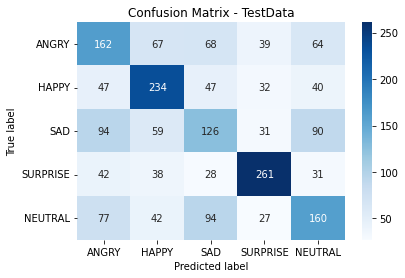

Plotting the Confusion Matrix


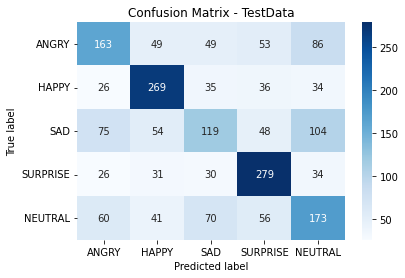

Plotting the Confusion Matrix


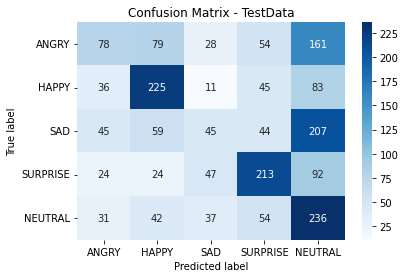

In [ ]:
plot_confusion_matrix(y_test,y_pred1)
plot_confusion_matrix(y_test,y_pred2)
plot_confusion_matrix(y_test,y_pred3)

### Simple models with pixel by pixel rbg values

In [ ]:
X = np.load('pureX.npy')
Y = np.load('dataY.npy')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,random_state=42)
lr = LogisticRegression(solver='lbfgs',multi_class='multinomial')
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

0.4075

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

0.38

In [ ]:
dt = DecisionTreeClassifier(max_depth=40)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

0.364

### Example

In [ ]:
x_image = np.array( [np.fromstring(df['pixels'][i], dtype=np.uint8, sep=" ") for i in range(len(df))] ) 

y_image = np.array( [df['emotion'][i] for i in range(len(df)) ])

X_train, X_test, y_train, y_test = train_test_split(x_image, y_image, test_size=0.1,random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)

print ("training knn model ...")
knn.fit(X_train, y_train)

print ("Predict for KNN Model")
y_pred_knn = knn.predict(X_test)

print ("KNN Test Accuracy on raw image inputs:", metrics.accuracy_score(y_test, y_pred_knn))

training knn model ...
Predict for KNN Model
KNN Test Accuracy on raw image inputs: 0.359
